# Armaments Applied to Other Mod Armies
v0.4.1
I was too lazy to spend two hours hand modifying all the armies from other mods in which someone else had not already added. So I spent thrice as many hours scripting this which should be able to handle anyone's modded armies and add reasonable armament costs and upkeeps to them. Or soon will at least.

This pipeline is designed around the use of Irony Mod Manager making a snap shots of the mods and merging them together. The target folder for input should be where your ironymodmanager's mod in questions's army folder is. It will then edit the same files. This piple (will) take into account duplicates from patch files.

In [1]:
# Configuration Section: Adjust commonly used variables here

# ------------------------------------------------------- Load -----------------------------------------------------------
input_directory = r"C:\\Users\\Aaron\\Documents\\Paradox Interactive\\Stellaris\\mod\\(Merged)_3.14_Full\\common\\armies"

# ------------------------------------------------------------------------------------------------------------------------
#   Threshold factors for damping (eg If say ACOT is a mod involved and has super stat armies. Remember ACOT lore says
# the tech is so advanced that early-game stuff is way easier, so it's ok if something costing 50,000 armaments now 
# costs only 12000.
# ------------------------------------------------------------------------------------------------------------------------
COST_THRESHOLD_FACTOR = 1.15
COST_EXPONENT_FACTOR = 0.0003
UPKEEP_THRESHOLD_FACTOR = 1.0
UPKEEP_EXPONENT_FACTOR = 0.0001

# ------------------------------------------------------------------------------------------------------------------------
# Rounding settings (Keeps numbers clean): 
#     UPPER_MULTIPLE: Armament costs are rounded to the nearest multiple of this value (so it looks boring like
#                        240 Armaments on screen rather than something suave like 139.6)
#     LOWER_MULTIPLE: If the above variable quite large, too many low cost predictions will round to 0, a few make 
#                        sense, but not too many.
# ------------------------------------------------------------------------------------------------------------------------
UPPER_MULTIPLE = 10
LOWER_MULTIPLE = 1

# ------------------------------------------------------------------------------------------------------------------------
# Psi-specific adjustments:
#     PSI_ARMAMENT_COST_FACTOR: Percentage of the armament cost used in psi adjustments (as a decimal, e.g., 0.5 for 50%).
#     PSI_DIVISOR: Divisor used to calculate the Zro cost for Psi-related armies.
# ------------------------------------------------------------------------------------------------------------------------
PSI_ARMAMENT_COST_FACTOR = 0.5
PSI_DIVISOR = 4


## Table of Contents
1. [Imports](#imports)
2. [Data Parsing](#parsing)
3. [Data Cleaning and Processing](#3-data-cleaning-and-processing)
4. [Damping](#4-damping)
5. [Visualization Scripts](#5-visualization-scripts)
6. [Common Functions](#6-common-functions)
8. [Army Type Outputs](#7-army-type-outputs)
   - [Armament Armies](#armament)
   - [Armies with Morale](#with-morale)
   - [Armies without Morale](#no-morale)
   - [Defensive Armies](#defensive)
   - [Spawned Armies](#spawned)
9. [Overwrite Data](#overwrite)

## 1. Imports <a class="anchor" id="imports"></a>

In [2]:
import os
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from IPython.display import HTML, display

<a class="anchor" id="parsing"></a>
## 2. Data Parsing 

In [3]:
def parse_army_files(input_directory):
    """
    Parse text files containing Stellaris army definitions.
    """
    army_data = []
    level_1_attributes = set()
    level_2_attributes = set()

    
    def parse_block(block, depth):
        data = {}
        lines = block.splitlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line.startswith("#"):
                i += 1
                continue
            if "=" in line and not line.endswith("{"):
                key, value = map(str.strip, line.split("=", 1))
                key = key.rstrip("=").strip()
                data[key] = value
                if depth == 1:
                    level_1_attributes.add(key)
            elif line.endswith("{"):
                key = line[:-1].strip().rstrip("=").strip()
                if depth == 1:
                    level_1_attributes.add(key)
                nested_block = []
                open_braces = 1
                i += 1
                while i < len(lines) and open_braces > 0:
                    nested_line = lines[i].strip()
                    if "{" in nested_line:
                        open_braces += 1
                    if "}" in nested_line:
                        open_braces -= 1
                    nested_block.append(nested_line)
                    i += 1
                nested_data = parse_block("\n".join(nested_block[:-1]), depth + 1)
                if key == "resources":
                    for sub_key in nested_data.keys():
                        level_2_attributes.add(sub_key)
                data[key] = nested_data
                continue
            i += 1
        return data

    for file_name in os.listdir(input_directory):
        if file_name.endswith(".txt"):
            with open(os.path.join(input_directory, file_name), "r", encoding="utf-8") as f:
                content = f.read()
            matches = re.finditer(r"^([a-zA-Z0-9_]+)\s*=\s*\{", content, re.MULTILINE)
            for match in matches:
                army_name = match.group(1).strip()
                start_pos = match.end()
                open_braces = 1
                end_pos = start_pos
                while open_braces > 0 and end_pos < len(content):
                    if content[end_pos] == "{":
                        open_braces += 1
                    elif content[end_pos] == "}":
                        open_braces -= 1
                    end_pos += 1
                block_content = content[start_pos:end_pos - 1]
                army_info = parse_block(block_content, 1)
                army_data.append({"name": army_name, **army_info})

    return army_data, level_1_attributes, level_2_attributes

<a class="anchor" id="data-cleaning"></a>
## 3. Data Cleaning and Processing 

In [4]:
def get_sub_df(input_directory):
    """
    Create a DataFrame of armies, extracting relevant columns and
    converting cost/upkeep dictionaries into numeric columns.
    """
    army_data, level_1_attributes, level_2_attributes = parse_army_files(input_directory)
    if not army_data:
        raise ValueError("No data was parsed. Check the Stellaris configuration files.")

    all_columns = ["name"] + sorted(list(level_1_attributes)) + sorted(list(level_2_attributes))
    rows = []
    for army in army_data:
        row = {"name": army.get("name", "")}
        for col in level_1_attributes:
            row[col] = army.get(col, "")
        resources = army.get("resources", {})
        for col in level_2_attributes:
            row[col] = resources.get(col, "")
        rows.append(row)

    df = pd.DataFrame(rows, columns=all_columns)

    # Drop extraneous columns
    cols_to_remove = ['resources', 'icon_frame', 'icon', 'occupation', 'use_armynames_from']
    df.drop(columns=[c for c in cols_to_remove if c in df.columns], inplace=True)

    # Keep only essential attributes
    keep = ['name', 'time', 'damage', 'health', 'morale_damage', 'morale', 'collateral_damage', 'cost', 'upkeep', 'defensive', 
        'war_exhaustion']
    
    df = df[keep].copy()

    # Convert the 'cost' and 'upkeep' columns from strings to dicts
    def convert_to_dict(entry):
        if isinstance(entry, str):
            try:
                return ast.literal_eval(entry)
            except (ValueError, SyntaxError):
                return {}
        elif isinstance(entry, float) or entry is None:
            return {}
        return entry

    df['cost'] = df['cost'].apply(convert_to_dict)
    df['upkeep'] = df['upkeep'].apply(convert_to_dict)

    
    # Expand cost & upkeep dicts into numeric columns
    def parse_resources_column(df_local, column):
        resource_keys = set()
        for entry in df_local[column].dropna():
            if isinstance(entry, dict):
                resource_keys.update(entry.keys())
        for key in resource_keys:
            df_local[f"{column}_{key}"] = df_local[column].apply(
                lambda x: float(x[key]) if isinstance(x, dict) and key in x else 0.0
            )
        return df_local

    df = parse_resources_column(df, 'cost')
    df = parse_resources_column(df, 'upkeep')
    df.drop(columns=['cost', 'upkeep'], inplace=True)

    # Identify relevant numeric columns dynamically
    numeric_cols = ['time', 'morale', 'damage', 'health', 'morale_damage', 
                    'collateral_damage', 'war_exhaustion']
    
    # Dynamically include all cost_* and upkeep_* columns
    cost_cols = [col for col in df.columns if col.startswith('cost_')]
    upkeep_cols = [col for col in df.columns if col.startswith('upkeep_')]
    
    # Combine all numeric columns
    all_numeric_cols = numeric_cols + cost_cols + upkeep_cols
    
    # Convert to numeric and handle 'time' as integer
    df[all_numeric_cols] = df[all_numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Ensure cost_* columns and 'time' are integers
    df[cost_cols + ['time']] = df[cost_cols + ['time']].astype(int)

    return df

<a class="anchor" id="damping"></a>
## 4. Damping

In [5]:
dampening_config = {
    'cost_sr_armaments':  {'threshold_factor': COST_THRESHOLD_FACTOR, 'exponent_factor': COST_EXPONENT_FACTOR},
    'upkeep_sr_armaments': {'threshold_factor': UPKEEP_THRESHOLD_FACTOR, 'exponent_factor': UPKEEP_EXPONENT_FACTOR},
}

def apply_dampening(df, armament_df):
    """
    Exponential dampening of cost_sr_armaments and upkeep_sr_armaments columns,
    referencing the peak from 'armament_df'.
    """
    debug_info = {}

    # Dampening for cost_sr_armaments
    if 'cost_sr_armaments' in df.columns:
        peak_cost = armament_df['cost_sr_armaments'].max()
        if pd.notnull(peak_cost) and peak_cost > 0:
            cost_settings = dampening_config['cost_sr_armaments']
            cost_threshold_value = cost_settings['threshold_factor'] * peak_cost
            cost_exponent_factor = cost_settings['exponent_factor']

            def dampen_cost(x):
                if x <= cost_threshold_value:
                    return x
                diff = x - cost_threshold_value
                return cost_threshold_value + diff / (1 + cost_exponent_factor * diff)

            df['cost_sr_armaments'] = df['cost_sr_armaments'].apply(dampen_cost)

    # Dampening for upkeep_sr_armaments
    if 'upkeep_sr_armaments' in df.columns:
        peak_upkeep = armament_df['upkeep_sr_armaments'].max()
        if pd.notnull(peak_upkeep) and peak_upkeep > 0:
            upkeep_settings = dampening_config['upkeep_sr_armaments']
            upkeep_threshold_value = upkeep_settings['threshold_factor'] * peak_upkeep
            upkeep_exponent_factor = upkeep_settings['exponent_factor']

            def dampen_upkeep(x):
                if x <= upkeep_threshold_value:
                    return x
                diff = x - upkeep_threshold_value
                return upkeep_threshold_value + diff / (1 + upkeep_exponent_factor * diff)

            df['upkeep_sr_armaments'] = df['upkeep_sr_armaments'].apply(dampen_upkeep)

    return df

## 5. Visualization Scripts <a class="anchor" id="visual"></a>

In [6]:
def reorder_columns(df):
    """
    Reorder DataFrame columns to prioritize key attributes:
    name, time, health, damage, morale, morale_damage, collateral_damage,
    cost_sr_armaments, upkeep_sr_armaments.
    Any remaining columns are appended in alphabetical order.
    """
    
    preferred_cols = ["name", "time", "health", "damage", "morale", "morale_damage", "collateral_damage", "war_exhaustion",
        "cost_sr_armaments", "upkeep_sr_armaments"]
    
    # Identify remaining columns not in preferred_cols
    remaining_cols = [col for col in df.columns if col not in preferred_cols]
    
    # Sort remaining columns by frequency of non-zero values (descending), then alphabetically
    non_zero_counts = df[remaining_cols].astype(bool).sum().sort_values(ascending=False)
    sorted_remaining = sorted(
        remaining_cols,
        key=lambda x: (-non_zero_counts.get(x, 0), x)
    )
    
    # Final column order
    final_cols = [col for col in preferred_cols if col in df.columns] + sorted_remaining
    return df[final_cols]


def display_scrollable_df(df, max_height=800, max_width=1500):
    """
    Reorder columns, apply specific formatting, highlight non-zero cost/upkeep cells
    with different colors, and display the DataFrame in a scrollable HTML container with a sticky header.
    """
    # Reorder columns as specified
    df_ordered = reorder_columns(df)
    
    # Identify cost and upkeep columns for highlighting
    cost_cols = [c for c in df_ordered.columns if "cost" in c.lower()]
    upkeep_cols = [c for c in df_ordered.columns if "upkeep" in c.lower()]

    # Define cost and upkeep highlighting logic
    def highlight_cells(row, highlight_color):
        return [
            f"background-color: {highlight_color}" if (isinstance(val, (int, float)) and val != 0) else ""
            for val in row
        ]

    # Apply styling
    styler = df_ordered.style
    if cost_cols:
        styler = styler.apply(highlight_cells, subset=cost_cols, axis=1, highlight_color="#fffbcc")
    if upkeep_cols:
        styler = styler.apply(highlight_cells, subset=upkeep_cols, axis=1, highlight_color="#ccf2ff")

    # Define formatting for specific columns
    formatting_dict = {}
    if "cost_sr_armaments" in df_ordered.columns:
        formatting_dict["cost_sr_armaments"] = "{:.0f}"  # No decimals
    if "upkeep_sr_armaments" in df_ordered.columns:
        formatting_dict["upkeep_sr_armaments"] = "{:.1f}"  # One decimal
    if "morale" in df_ordered.columns:
        formatting_dict["morale"] = "{:.2f}"  # Two decimals
    
    # Apply formatting
    styler = styler.format(formatting_dict)
    
    # Hide the index using Styler's built-in method
    styler = styler.hide(axis="index")
    
    # Define CSS for a sticky header
    css = f"""
    <style>
        .dataframe-container {{
            max-height: {max_height}px;
            max-width: {max_width}px;
            overflow: auto;
            border: 1px solid #ccc;
        }}
        .dataframe-container table {{
            width: 100%;
            table-layout: auto;  /* Allow table to resize column widths dynamically */
            border-collapse: collapse;
        }}
        .dataframe-container th, .dataframe-container td {{
            padding: 8px;  /* Add padding to cells */
            text-align: left;  /* Align text for better readability */
            border: 1px solid #ddd;  /* Add cell borders */
        }}
        .dataframe-container th {{
            position: sticky;
            top: 0;
            background: #f4f4f4;
            z-index: 1;
        }}
    </style>>
    """

    # Render the styled DataFrame to HTML using to_html()
    html_table = styler.to_html()

    # Wrap the HTML table in a scrollable container with sticky header CSS
    scrollable_html = f"""
    {css}
    <div class='dataframe-container'>
        {html_table}
    </div>
    """
    display(HTML(scrollable_html))
    

# Scatter Plot Function for Costs and Upkeep
def scatter_charts(df, attributes, target_col, title_prefix, color, figsize=(14, 10)):
    """
    Generate scatter charts showing the relationship between features and a target column.

    Parameters
    ----------
    df_with_morale : pandas.DataFrame
        DataFrame for armies with morale.
    df_no_morale : pandas.DataFrame
        DataFrame for armies without morale.
    features : list
        List of features to compare against the target column.
    target_col : str
        Target column (e.g., cost_sr_armaments, upkeep_sr_armaments).
    title_prefix : str
        Title prefix to describe the type of army.
    """
    num_attributes = len(attributes)
    num_cols = 2  # Display 2 plots per row
    num_rows = (num_attributes + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, attribute in enumerate(attributes):
        ax = axes[i]
        ax.scatter(df[attribute], df[target_col], alpha=0.6, color=color)
        ax.set_title(f"{title_prefix}: vs {attribute}")
        ax.set_xlabel(attribute)
        ax.set_ylabel(target_col.split('_')[-1].capitalize())
        ax.grid(True)

    # Turn off unused subplots
    for i in range(len(attributes), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## 6. Common Functions <a class="anchor" id="common-functions"></a>

In [7]:
def fit_pls_model(armies_df, features, target_col, n_components=2):
    """
    Fit a partial least squares regression model.
    """
    if armies_df.empty:
        raise ValueError(f"DataFrame is empty for '{target_col}'.")
    df_local = armies_df.dropna(subset=features + [target_col]).copy()
    if df_local.empty:
        raise ValueError(f"All rows dropped for '{target_col}' after dropna on {features} and target.")
    X = df_local[features].fillna(0).values
    y = df_local[target_col].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y)
    return pls, scaler


def predict_pls(armies_df, features, pls_model, scaler):
    """
    Use the PLS model to predict cost/upkeep for armies.
    """
    X = armies_df[features].fillna(0).values
    X_scaled = scaler.transform(X)
    preds = pls_model.predict(X_scaled).ravel()
    return np.clip(preds, a_min=0, a_max=None)


def round_cost_upkeep(df_local, cost_col='cost_sr_armaments', upkeep_col='upkeep_sr_armaments'):
    """
    Round costs dynamically based on two multiples:
    - Round to the nearest LOWER_MULTIPLE if value ≤ UPPER_MULTIPLE.
    - Round to the nearest UPPER_MULTIPLE if value > UPPER_MULTIPLE.
    """
    # Define multiples

    def dynamic_round(value):
        if value > UPPER_MULTIPLE:
            return UPPER_MULTIPLE * round(value / UPPER_MULTIPLE)
        return LOWER_MULTIPLE * round(value / LOWER_MULTIPLE)

    if cost_col and (cost_col in df_local.columns):
        df_local[cost_col] = pd.to_numeric(df_local[cost_col], errors='coerce').fillna(0)
        df_local[cost_col] = df_local[cost_col].apply(dynamic_round)

    if upkeep_col and (upkeep_col in df_local.columns):
        df_local[upkeep_col] = pd.to_numeric(df_local[upkeep_col], errors='coerce').fillna(0)
        df_local[upkeep_col] = (np.ceil(df_local[upkeep_col] / 0.25) * 0.25).round(2)
        df_local[upkeep_col] = df_local[upkeep_col].apply(lambda x: float(x) if x == int(x) else x)

    return df_local


def round_all_cost_upkeep_columns(df):
    """
    Rounds all cost_ columns to int, and all upkeep_ columns to two decimals.
    Ensures no trailing zeros in upkeep columns if the final value is an integer.
    Also ensures 'time' is rounded to integer.
    """
    cost_cols = [c for c in df.columns if c.lower().startswith("cost_")]
    upkeep_cols = [c for c in df.columns if c.lower().startswith("upkeep_")]

    # Round cost columns to integers
    for col in cost_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[col] = (df[col] // 10 * 10).astype(int)  # Ensure integer rounding in multiples of 10

    # Round upkeep columns to two decimals, then remove trailing .00
    for col in upkeep_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        df[col] = (np.ceil(df[col] / 0.25) * 0.25).round(2)  # Round to 0.25 increments
        df[col] = df[col].apply(lambda x: int(x) if x.is_integer() else x)

    # Ensure 'time' is an integer
    if 'time' in df.columns:
        df['time'] = pd.to_numeric(df['time'], errors='coerce').fillna(0).astype(int)

    return df



def round_all_relevant_columns(df):
    """
    Round specified columns to appropriate decimal places.
    Ensures no trailing zeros in upkeep columns if the final value is an integer.
    """
    # Define rounding specifications for columns
    rounding_specs = {
        'health': 0,
        'damage': 0,
        'morale_damage': 2,
        'collateral_damage': 2,
        'war_exhaustion': 2 
    }

    # Dynamically identify upkeep columns and set rounding to 2 decimals
    upkeep_cols = [col for col in df.columns if col.lower().startswith('upkeep_')]
    for col in upkeep_cols:
        rounding_specs[col] = 2

    # Apply rounding
    for col, decimals in rounding_specs.items():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            df[col] = df[col].round(decimals)
            if decimals > 0:  # Remove trailing zeros if rounded value is integer
                df[col] = df[col].apply(lambda x: float(x) if x != int(x) else int(x))

    return df


def adjust_psi_costs(df, cost_col='cost_sr_armaments', upkeep_col='upkeep_sr_armaments', zro_col='cost_sr_zro'):
    """
    Adjust Psi-related armies:
    - For armies with '*psi*' or '*Psi*' in their name:
      - Reduce armament cost by PSI_ARMAMENT_COST_FACTOR (e.g., 50% reduction).
      - Add (PSI_ARMAMENT_COST_FACTOR * armament cost / PSI_DIVISOR) to the Zro cost column.
      - Reduce armament upkeep by PSI_ARMAMENT_COST_FACTOR (e.g., 50% reduction).
      - Add (PSI_ARMAMENT_COST_FACTOR * armament upkeep / PSI_DIVISOR) to the Zro upkeep column.
    """
    if zro_col not in df.columns:
        df[zro_col] = 0  # Initialize cost_sr_zro as integer column

    # Identify Psi-related armies
    psi_mask = df['name'].str.contains(r'psi', case=False, na=False)

    # Adjust Armament Cost (integer-based)
    psi_cost_reduction = (df.loc[psi_mask, cost_col] * PSI_ARMAMENT_COST_FACTOR).round().astype(int)
    df.loc[psi_mask, cost_col] -= psi_cost_reduction
    df.loc[psi_mask, zro_col] += (psi_cost_reduction / PSI_DIVISOR).round().astype(int)

    # Adjust Upkeep (float-based)
    psi_upkeep_reduction = (df.loc[psi_mask, upkeep_col] * PSI_ARMAMENT_COST_FACTOR).round(2)
    df.loc[psi_mask, upkeep_col] -= psi_upkeep_reduction
    df.loc[psi_mask, upkeep_col] += ((psi_upkeep_reduction) / PSI_DIVISOR).round(2)

    return df

## 7. Main <a class="anchor" id="main"></a>

In [8]:
def main():
    """
    Pipeline:
      1. Load the full DataFrame of armies from get_sub_df.
      2. Identify & separate:
         a) Original armament armies (armament_df_original).
         b) Spawned armies (time=0, not defensive).
         c) Normal armies with no armaments (those that need new cost/upkeep).
         d) Defensive armies, etc.
      3. Fit PLS using only armament_df_original.
      4. Predict cost/upkeep for normal no-armament armies.
         - Apply cost & upkeep for them, dampen, round, etc.
      5. Predict upkeep only for spawned armies (split morale/no morale).
      6. Display the final separate tables.
    """

    # ----------------- Load & prep data ---------------------
    df = get_sub_df(input_directory)

    # 1) armament_df_original: these start with cost/upkeep > 0
    armament_df = df[(df['cost_sr_armaments'] > 0) | (df['upkeep_sr_armaments'] > 0)].copy()
    defensive_df = df[df['defensive'] == "yes"].copy()

    cost_cols = [c for c in df.columns if c.startswith("cost_")]
    upkeep_cols = [c for c in df.columns if c.startswith("upkeep_")]

    zero_cost_upkeep_mask = (df[cost_cols + upkeep_cols].sum(axis=1) == 0)
    spawned_df = df[zero_cost_upkeep_mask & (df['defensive'] != "yes")].copy()

    remainder_df = df[
        ~df.index.isin(armament_df.index) & ~df.index.isin(defensive_df.index) & ~df.index.isin(spawned_df.index)
    ].copy()

    # ------------------------ Define metrics ----------------------------
    metrics_with_morale = ['time', 'damage', 'health', 'morale_damage', 'collateral_damage', 'war_exhaustion', 'morale']
    metrics_no_morale = ['time', 'damage', 'health', 'morale_damage', 'collateral_damage', 'war_exhaustion']

    # -------------------- SPLIT NO-ARMAMENT BY MORALE --------------------
    with_morale = remainder_df[(remainder_df['morale'] > 0) & (remainder_df['time'] > 0)].copy()
    no_morale = remainder_df[(remainder_df['morale'] <= 0) & (remainder_df['time'] > 0)].copy()

    # Convert numeric columns to avoid errors downstream
    for m in metrics_with_morale:
        with_morale[m] = pd.to_numeric(with_morale[m], errors='coerce').fillna(0)
    for m in metrics_no_morale:
        no_morale[m] = pd.to_numeric(no_morale[m], errors='coerce').fillna(0)

    # -------------- Fit PLS on armament_df_original --------------
    armament_with_morale = armament_df[armament_df['morale'] > 0].copy()
    armament_no_morale = armament_df[armament_df['morale'] <= 0].copy()

    # Convert numeric in the armament subsets
    for m in metrics_with_morale:
        armament_with_morale[m] = pd.to_numeric(armament_with_morale[m], errors='coerce').fillna(0)
    for m in metrics_no_morale:
        armament_no_morale[m] = pd.to_numeric(armament_no_morale[m], errors='coerce').fillna(0)

    # Fit cost models
    cost_model_with, scaler_cost_with = fit_pls_model(armament_with_morale, metrics_with_morale, 'cost_sr_armaments')
    cost_model_no, scaler_cost_no = fit_pls_model(armament_no_morale, metrics_no_morale, 'cost_sr_armaments')

    # Fit upkeep models
    upkeep_model_with, scaler_upkeep_with = fit_pls_model(armament_with_morale, metrics_with_morale, 'upkeep_sr_armaments')
    upkeep_model_no, scaler_upkeep_no = fit_pls_model(armament_no_morale, metrics_no_morale, 'upkeep_sr_armaments')

    # ------------------ WITH Morale -------------------
    with_morale['cost_sr_armaments'] = predict_pls(
        with_morale, metrics_with_morale, cost_model_with, scaler_cost_with
    ).round(0)
    with_morale['upkeep_sr_armaments'] = predict_pls(
        with_morale, metrics_with_morale, upkeep_model_with, scaler_upkeep_with
    ).round(1)

    # Apply damping to costs and upkeep
    with_morale = apply_dampening(with_morale, armament_with_morale)   
    with_morale = round_cost_upkeep(with_morale)

    # ------------------ NO Morale -------------------
    no_morale['cost_sr_armaments'] = predict_pls(
        no_morale, metrics_no_morale, cost_model_no, scaler_cost_no
    ).round(0)
    no_morale['upkeep_sr_armaments'] = predict_pls(
        no_morale, metrics_no_morale, upkeep_model_no, scaler_upkeep_no
    ).round(1)

    # Apply damping to costs and upkeep
    no_morale = apply_dampening(no_morale, armament_no_morale)
    no_morale = round_cost_upkeep(no_morale)

    # -------------------------------------------------------
    #  9) Display
    # -------------------------------------------------------

    # Apply Psi-specific adjustments for both cost and upkeep
    with_morale = adjust_psi_costs(with_morale)
    no_morale = adjust_psi_costs(no_morale)
    
    # Apply rounding to all tables before display
    with_morale = round_all_relevant_columns(with_morale)
    no_morale = round_all_relevant_columns(no_morale)
    spawned_df = round_all_relevant_columns(spawned_df)
    defensive_df = round_all_relevant_columns(defensive_df)
    armament_df = round_all_relevant_columns(armament_df)

    return armament_df, with_morale, no_morale, defensive_df, spawned_df

armament_df, with_morale, no_morale, defensive_df, spawned_df = main()

## 8. Army Type Outputs <a class="anchor" id="army-types"></a>

### Armament Armies <a class="anchor" id="armament"></a>

In [9]:
# Display logic for Armament Armies
def display_armament_armies(armament_df):
    display(HTML(f"<h2>Armies W/ Armaments (count: {len(armament_df)})</h2>"))
    display_scrollable_df(armament_df)

display_armament_armies(armament_df)

name,time,health,damage,morale,morale_damage,collateral_damage,war_exhaustion,cost_sr_armaments,upkeep_sr_armaments,cost_minerals,upkeep_energy,cost_unity,cost_alloys,cost_energy,cost_influence,upkeep_minerals,upkeep_alloys,cost_rare_crystals,cost_minor_artifacts,upkeep_minor_artifacts,upkeep_rare_crystals,cost_acot_sr_stellarite,cost_sr_zro,cost_acot_sr_dark_energy,cost_exotic_gases,cost_sr_dark_matter,cost_volatile_motes,upkeep_sr_zro,upkeep_unity,upkeep_acot_sr_stellarite,cost_acot_sr_light_matter,cost_astral_threads,cost_food,defensive,upkeep_food
heavy_assault_army,180,2.000000,2.000000,1.00,1.000000,2.000000,1.500000,300,2.0,300,2.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
special_forces_army,180,1.000000,1.000000,2.50,3.500000,0.100000,1.000000,50,0.5,100,3.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
advanced_tank_army,240,3.000000,2.000000,2.00,1.250000,3.000000,2.000000,500,5.0,500,3.000000,0,200,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
purge_squads_army,120,1.000000,1.000000,1.25,1.250000,10.000000,1.000000,200,1.5,100,1.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
gunship_army,520,6.000000,4.000000,3.00,1.500000,5.000000,3.000000,2000,10.0,0,8.000000,0,500,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
mech_trooper_army,120,2.000000,1.000000,1.00,1.000000,1.200000,1.500000,300,1.5,150,2.000000,0,100,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
psionic_army_2,240,3.000000,2.000000,0.00,4.000000,0.500000,3.000000,100,0.5,500,3.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,100,0,0,0,0,0.200000,0,0,0,0,0,,0
clone_army2,25,1.000000,1.000000,1.25,0.000000,1.000000,0.500000,100,1.0,75,0.750000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
sup_sol_javelin,180,3.000000,3.000000,6.00,1.500000,0.250000,3.000000,200,2.0,500,5.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0
sup_sol_gene_warrior,180,3.000000,3.000000,6.00,1.500000,0.250000,3.000000,200,2.0,500,5.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,,0


### Armies with Morale <a class="anchor" id="with-morale"></a>

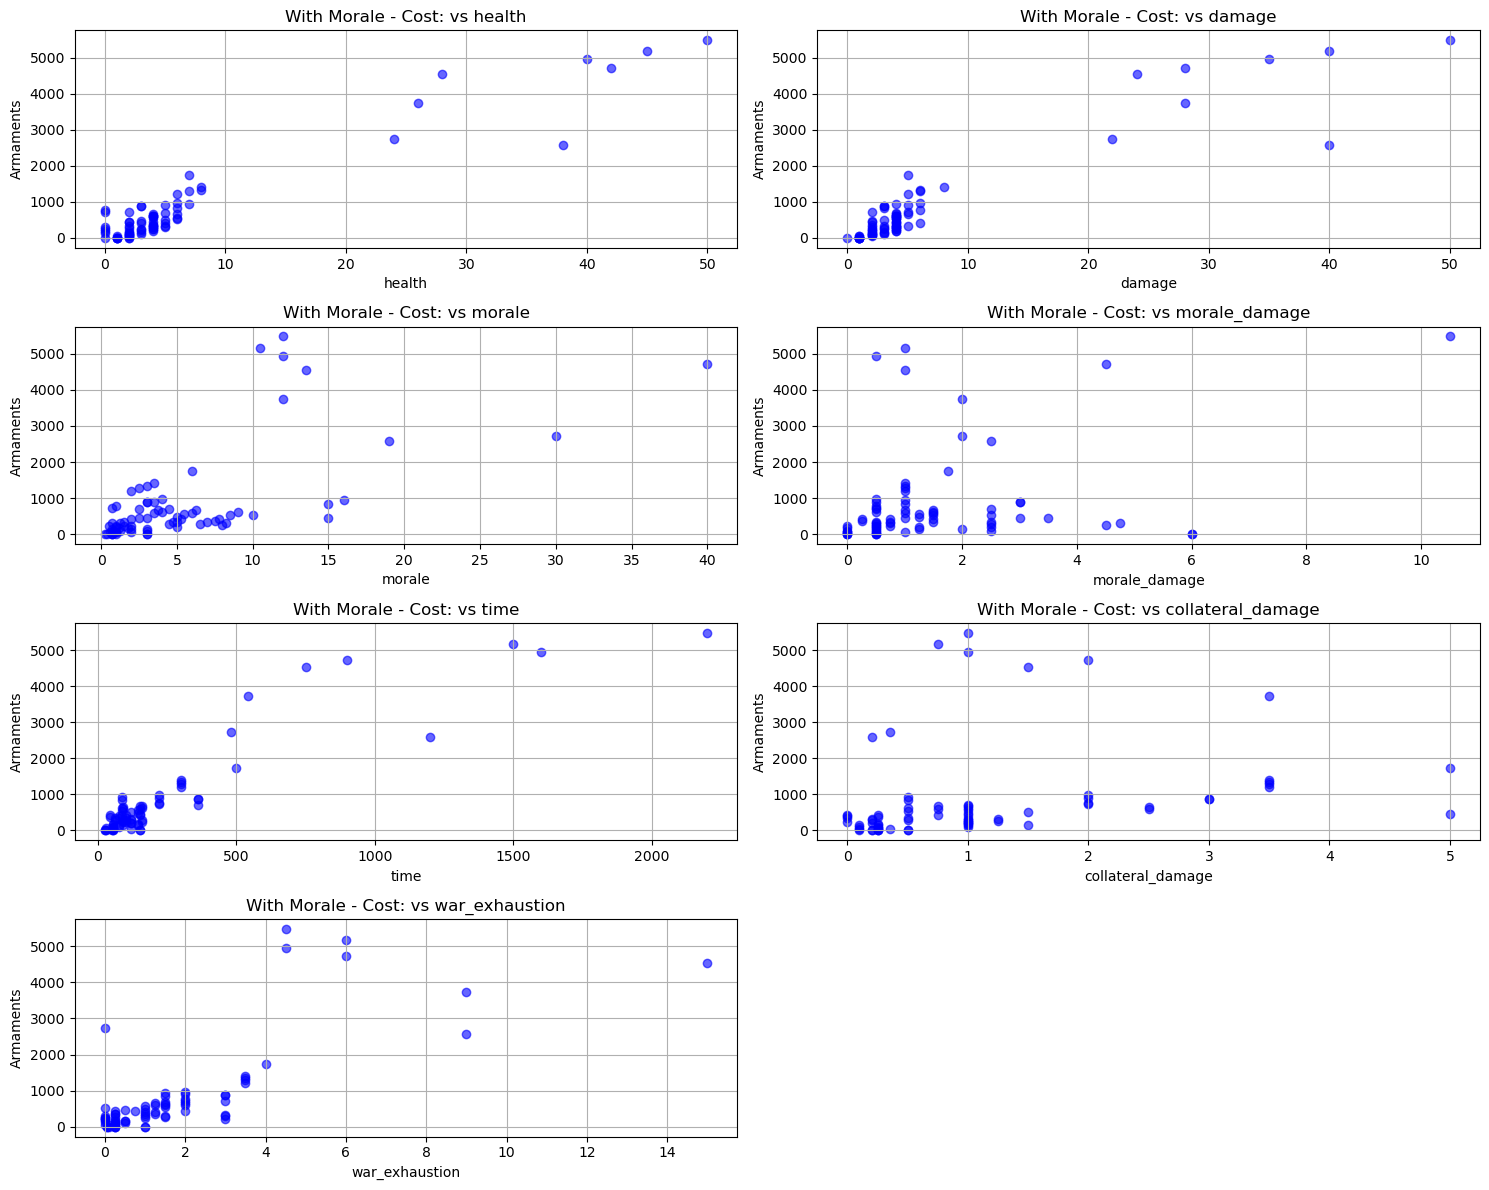

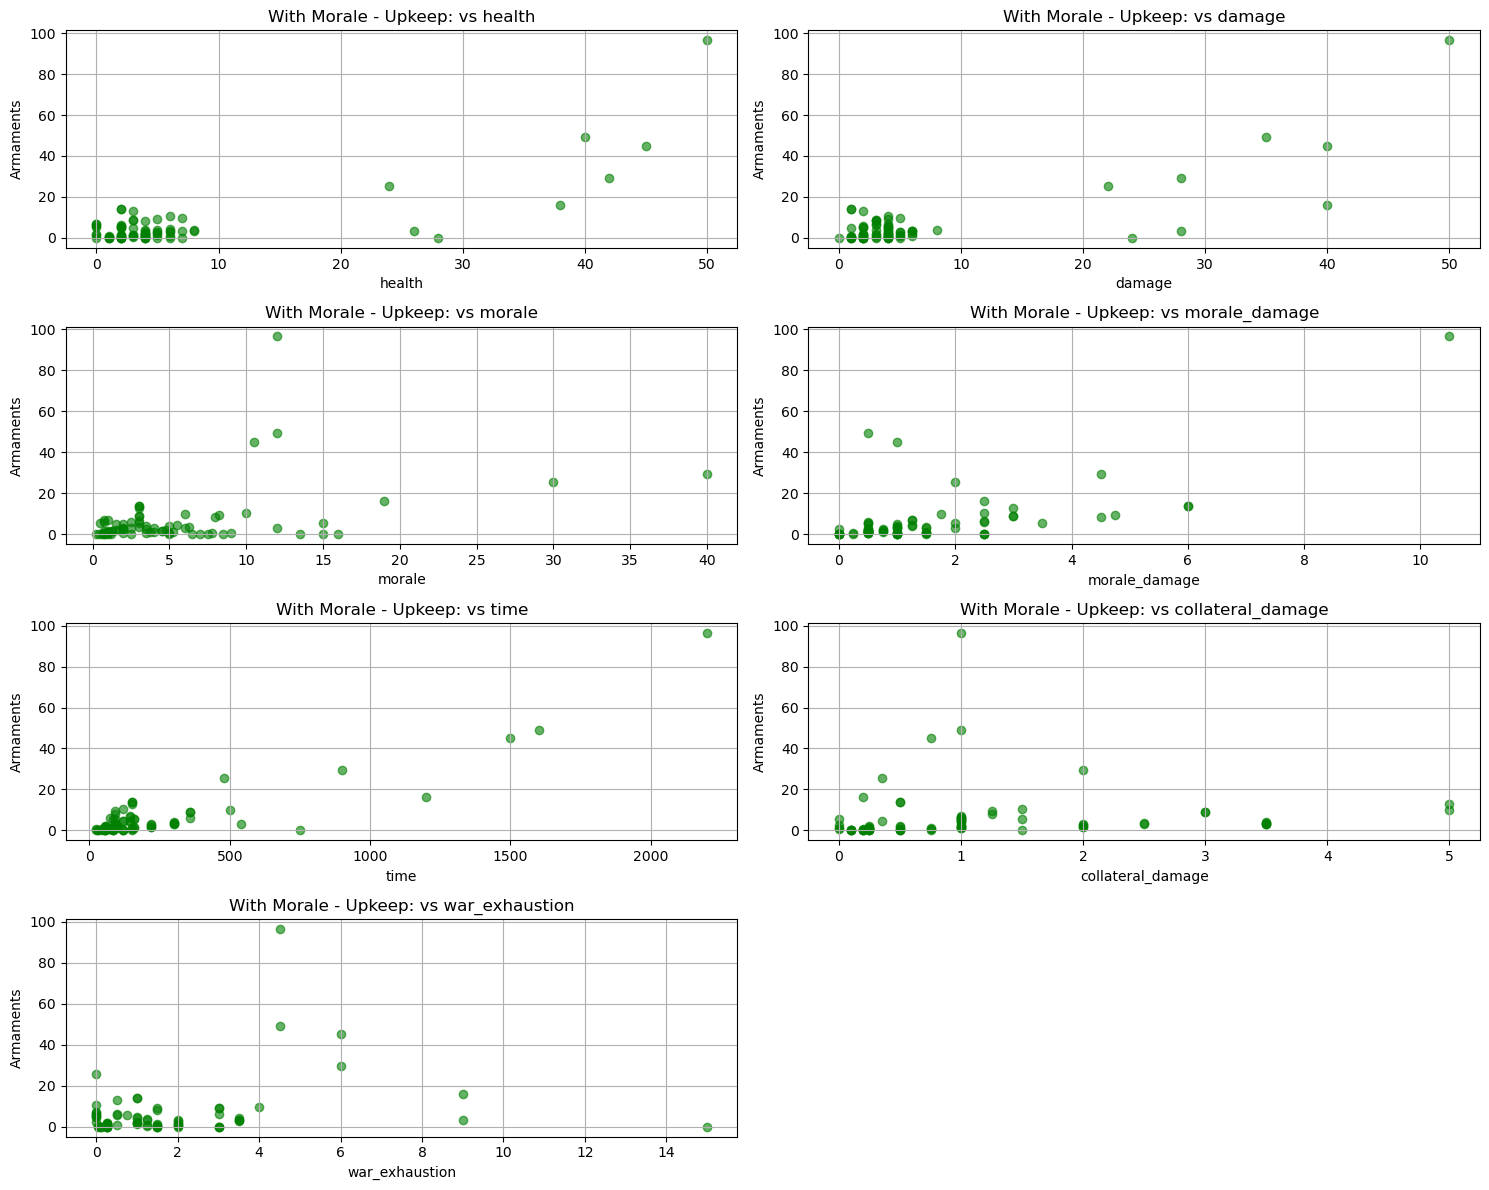

name,time,health,damage,morale,morale_damage,collateral_damage,war_exhaustion,cost_sr_armaments,upkeep_sr_armaments,cost_minerals,cost_unity,upkeep_energy,cost_acot_sr_dark_energy,cost_influence,cost_sr_dark_matter,cost_acot_sr_stellarite,cost_alloys,upkeep_alloys,cost_sr_zro,upkeep_food,cost_astral_threads,defensive,upkeep_minerals,cost_acot_sr_light_matter,cost_energy,cost_exotic_gases,cost_food,cost_minor_artifacts,cost_rare_crystals,cost_volatile_motes,upkeep_acot_sr_stellarite,upkeep_minor_artifacts,upkeep_rare_crystals,upkeep_sr_zro,upkeep_unity
acot_army_fe_spirit,85,2.000000,4.000000,15.00,3.500000,0.000000,0.750000,440,5.5,300,25,5.000000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_fe_phile,75,2.000000,2.000000,2.00,0.500000,0.250000,0.500000,150,0.8,300,25,5.000000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_fe_phobe,75,2.000000,3.000000,3.00,2.500000,1.000000,0.500000,100,6.2,300,25,5.000000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
assault_army,50,1.000000,1.000000,1.00,0.500000,0.250000,0.250000,0,0.5,100,0,0.500000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
slave_army,25,1.000000,1.000000,0.25,0.000000,0.200000,0.050000,0,0.0,20,0,0.100000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_slave_army_dm,25,1.000000,1.000000,0.75,0.500000,0.200000,0.050000,0,0.5,20,0,0.100000,0,0,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_mat_hero,750,28.000000,24.000000,13.50,1.000000,1.500000,15.000000,4540,0.0,0,0,0.000000,0,250,0,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_spirit,85,6.000000,3.000000,15.00,1.000000,0.500000,1.500000,840,0.0,300,30,0.000000,1,0,1,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_spirit_se,85,7.000000,4.000000,16.00,1.000000,0.500000,1.500000,940,0.0,350,35,0.000000,0,0,0,1,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_army_phobe,90,4.000000,4.000000,6.00,1.500000,2.500000,1.250000,600,3.2,350,35,0.000000,1,0,1,0,0,0.000000,0,0.000000,0,,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Display logic for Armies with Morale
def display_with_morale(with_morale):
    display(HTML(f"<h2>Newly Armed Mod Armies W/ Morale (count: {len(with_morale)})</h2>"))
    scatter_charts(with_morale, ['health', 'damage', 'morale', 'morale_damage', 'time', 'collateral_damage', 'war_exhaustion'], 'cost_sr_armaments', "With Morale - Cost", 'blue', figsize=(15, 12))
    scatter_charts(with_morale, ['health', 'damage', 'morale', 'morale_damage', 'time', 'collateral_damage', 'war_exhaustion'], 'upkeep_sr_armaments', "With Morale - Upkeep", 'green', figsize=(15, 12))
    display_scrollable_df(with_morale)

display_with_morale(with_morale)

### Armies without Morale <a class="anchor" id="no-morale"></a>

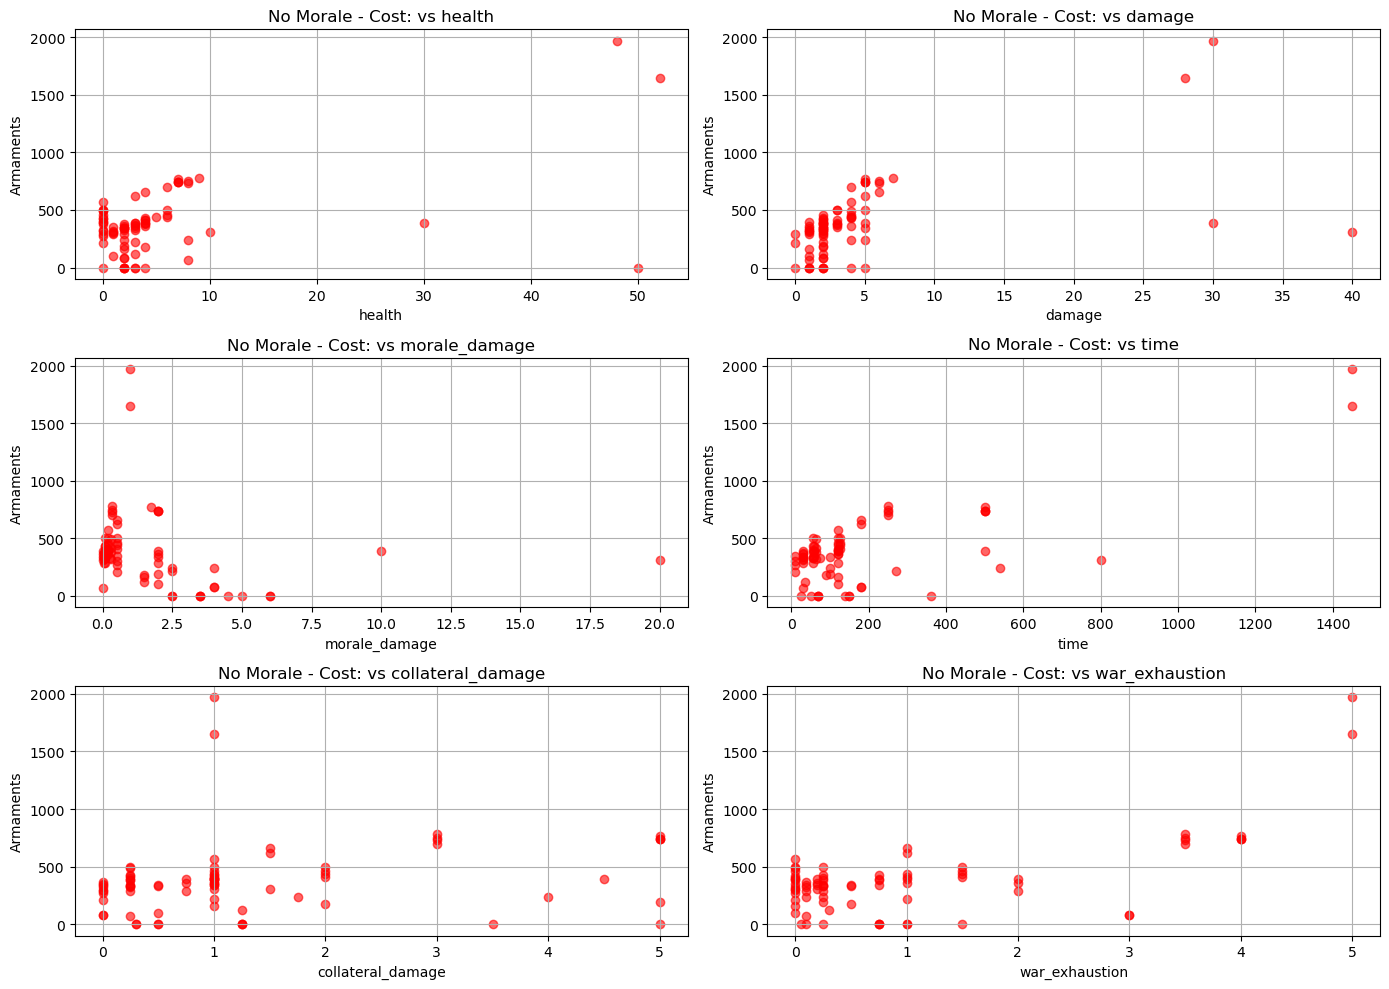

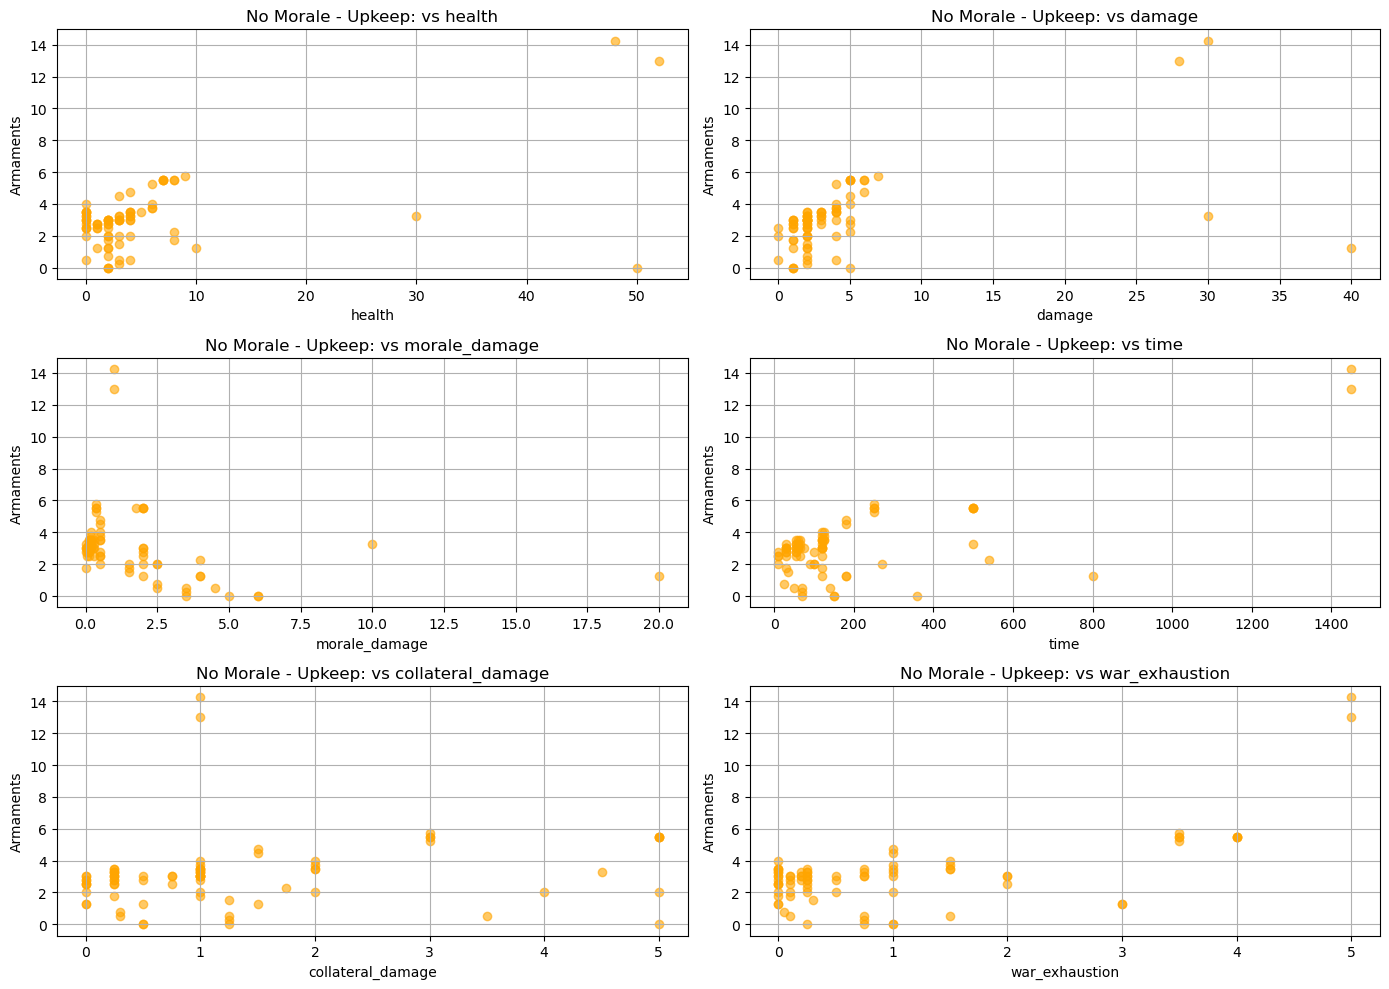

name,time,health,damage,morale,morale_damage,collateral_damage,war_exhaustion,cost_sr_armaments,upkeep_sr_armaments,cost_minerals,upkeep_energy,cost_alloys,upkeep_alloys,cost_unity,upkeep_minerals,cost_influence,cost_acot_sr_dark_energy,cost_energy,cost_sr_dark_matter,upkeep_food,cost_food,cost_acot_sr_light_matter,cost_acot_sr_stellarite,cost_astral_threads,cost_exotic_gases,cost_sr_zro,defensive,upkeep_unity,cost_minor_artifacts,cost_rare_crystals,cost_volatile_motes,upkeep_acot_sr_stellarite,upkeep_minor_artifacts,upkeep_rare_crystals,upkeep_sr_zro
acot_army_fe_mat,75,3.000000,2.000000,0.00,0.250000,0.500000,0.500000,330,3.0,300,5.000000,0,0.000000,25,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_army_fe_machine,30,8.000000,1.000000,0.00,0.000000,0.250000,0.100000,70,1.8,300,5.000000,0,0.000000,25,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_drone_army,30,0.000000,0.000000,0.00,0.050000,0.000000,0.100000,290,2.5,50,0.250000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_drone_army_dm,30,1.000000,2.000000,0.00,0.050000,0.000000,0.100000,320,2.8,60,0.300000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_drone_army_ae,30,2.000000,2.000000,0.00,0.050000,0.000000,0.100000,340,3.0,70,0.350000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_drone_army_se,30,3.000000,3.000000,0.00,0.050000,0.000000,0.100000,370,3.0,90,0.450000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
robotic_army,60,2.000000,1.000000,0.00,0.100000,1.000000,0.750000,340,3.0,150,1.500000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_droid_army_dm,60,2.000000,2.000000,0.00,0.100000,1.000000,0.750000,380,3.0,175,1.750000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_droid_army_ae,60,3.000000,2.000000,0.00,0.100000,1.000000,0.750000,390,3.2,200,2.000000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0
acot_droid_army_se,60,4.000000,4.000000,0.00,0.100000,1.000000,0.750000,430,3.5,250,2.500000,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,,0,0,0,0,0,0,0,0


In [11]:
def display_no_morale(no_morale):
    display(HTML(f"<h2>Newly Armed Mod Armies W/ No Morale (count: {len(no_morale)})</h2>"))
    scatter_charts(no_morale, ['health', 'damage', 'morale_damage', 'time', 'collateral_damage', 'war_exhaustion'], target_col='cost_sr_armaments', title_prefix='No Morale - Cost', color='red')
    scatter_charts(no_morale, ['health', 'damage', 'morale_damage', 'time', 'collateral_damage', 'war_exhaustion'], target_col='upkeep_sr_armaments', title_prefix='No Morale - Upkeep', color='orange')
    display_scrollable_df(no_morale)

display_no_morale(no_morale)

### Defensive Armies <a class="anchor" id="defensive"></a>

In [12]:
# Display logic for Defensive Armies
def display_defensive_armies(defensive_df):
    display(HTML(f"<h2>Defensive Armies (unmodified) (count: {len(defensive_df)})</h2>"))
    display_scrollable_df(defensive_df)

display_defensive_armies(defensive_df)

name,time,health,damage,morale,morale_damage,collateral_damage,war_exhaustion,cost_sr_armaments,upkeep_sr_armaments,defensive,upkeep_energy,upkeep_alloys,cost_acot_sr_dark_energy,cost_acot_sr_light_matter,cost_acot_sr_stellarite,cost_alloys,cost_astral_threads,cost_energy,cost_exotic_gases,cost_food,cost_influence,cost_minerals,cost_minor_artifacts,cost_rare_crystals,cost_sr_dark_matter,cost_sr_zro,cost_unity,cost_volatile_motes,upkeep_acot_sr_stellarite,upkeep_food,upkeep_minerals,upkeep_minor_artifacts,upkeep_rare_crystals,upkeep_sr_zro,upkeep_unity
hoplite_army,0,1.000000,1.000000,2.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
militia_army,0,1.000000,0.000000,5.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
enforcer_army,0,1.000000,1.000000,1.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
militia_drone_army,0,0.000000,0.000000,4.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
militia_robot_army,0,1.000000,1.000000,0.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
religious_army,0,1.000000,2.000000,8.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ind_mach_hoplite_army,0,1.000000,1.000000,2.00,1.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAA_insurgency_army,0,1.000000,1.000000,5.00,0.000000,5.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAA_revolt_army,0,1.000000,1.000000,1.00,0.000000,0.000000,0.000000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_defense_army_fe_mat,0,3.000000,2.000000,0.00,0.250000,0.000000,0.500000,0,0.0,yes,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Spawned Armies <a class="anchor" id="spawned"></a>

In [13]:
# Display logic for Spawned Armies
def display_spawned_armies(spawned_df):
    display(HTML(f"<h2>Spawned Armies (unmodified) (count: {len(spawned_df)})</h2>"))
    display_scrollable_df(spawned_df)

display_spawned_armies(spawned_df)

name,time,health,damage,morale,morale_damage,collateral_damage,war_exhaustion,cost_sr_armaments,upkeep_sr_armaments,defensive,cost_acot_sr_dark_energy,cost_acot_sr_light_matter,cost_acot_sr_stellarite,cost_alloys,cost_astral_threads,cost_energy,cost_exotic_gases,cost_food,cost_influence,cost_minerals,cost_minor_artifacts,cost_rare_crystals,cost_sr_dark_matter,cost_sr_zro,cost_unity,cost_volatile_motes,upkeep_acot_sr_stellarite,upkeep_alloys,upkeep_energy,upkeep_food,upkeep_minerals,upkeep_minor_artifacts,upkeep_rare_crystals,upkeep_sr_zro,upkeep_unity
prototype_super_soldier,0,4.000000,4.000000,0.00,0.000000,3.000000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_autoarmor,50,1.000000,1.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_autoarmor_se,50,2.000000,2.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_medium_autoarmor,50,2.000000,1.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_medium_autoarmor_se,50,3.000000,2.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_heavy_autoarmor,50,2.000000,2.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_infantry_heavy_autoarmor_se,50,3.000000,2.000000,0.00,0.100000,0.250000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_droid_army_torso,60,0.000000,1.000000,0.00,0.100000,1.000000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_droid_army_torso_dm,160,0.000000,2.000000,0.00,0.100000,1.000000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acot_droid_army_torso_ae,160,0.000000,2.000000,0.00,0.100000,1.000000,0.000000,0,0.0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Rewriting Armies <a class="anchor" id="overwrite"></a>

In [14]:
# Combine the DataFrames into `armament_data`
armament_data = pd.concat([no_morale, with_morale]).set_index('name')

# List all .txt files, skipping certain files
files_to_skip = [
    '00_armies_me.txt', '01_event_armies_me.txt', '02_super_soldier_armies_me.txt',
    '03_hive_armies_me.txt', '04_machine_armies.txt', 'AAA_defense_armies.txt',
    'override_armies_me.txt'
]
input_files = [
    f for f in os.listdir(input_directory)
    if f.endswith('.txt') and f not in files_to_skip
]

print(f"Files to process: {input_files}")

# Define the function to update resources
def update_resources(block, cost_sr, upkeep_sr):
    lines = block.splitlines()
    updated_lines = []
    inside_cost = False
    inside_upkeep = False
    indent_cost = None
    indent_upkeep = None

    for line in lines:
        stripped = line.strip()

        # Detect and handle cost block
        if "cost" in stripped and "=" in stripped and "{" in stripped:
            inside_cost = True
            indent_cost = len(line) - len(stripped) + 10  # Indentation for new line
            updated_lines.append(line)
            continue

        if inside_cost and stripped == "}":
            if cost_sr is not None:
                updated_lines.append(" " * indent_cost + f"sr_armaments = {cost_sr}")
            inside_cost = False

        # Detect and handle upkeep block
        if "upkeep" in stripped and "=" in stripped and "{" in stripped:
            inside_upkeep = True
            indent_upkeep = len(line) - len(stripped) + 10  # Indentation for new line
            updated_lines.append(line)
            continue

        if inside_upkeep and stripped == "}":
            if upkeep_sr is not None:
                updated_lines.append(" " * indent_upkeep + f"sr_armaments = {upkeep_sr}")
            inside_upkeep = False

        # Add the line to the updated block
        updated_lines.append(line)

    return "\n".join(updated_lines)


# Regex to match army blocks with resources
army_regex = r"^(\w+)\s*=\s*\{\s*(?:[^{}]*?\{[^{}]*?\}[^{}]*?)*?resources\s*=\s*\{\s*.*?\s*\}\s*\}"

def process_file(file_path, armament_data):
    #print(f"Processing file: {file_path}")
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Find all army blocks
    matches = list(re.finditer(army_regex, content, flags=re.DOTALL | re.MULTILINE))
    #print(f"  - Found {len(matches)} army blocks in {file_path}")

    updated_content = content  # Initialize with original content

    for match in matches:
        block = match.group(0)  # Full army block
        army_name = match.group(1)  # Army name
        #print(f"    - Processing army: {army_name}")

        # Check if the army name exists in the DataFrame
        if army_name in armament_data.index:
            cost_sr = armament_data.loc[army_name, 'cost_sr_armaments']
            upkeep_sr = armament_data.loc[army_name, 'upkeep_sr_armaments']
            #print(f"      - Found in DataFrame: cost_sr={cost_sr}, upkeep_sr={upkeep_sr}")

            # Update the block
            new_block = update_resources(block, cost_sr, upkeep_sr)

            # Debug: Show the original and updated blocks
            #print(f"      - Original block:\n{block}")
            #print(f"      - Updated block:\n{new_block}")

            # Replace the block in the content
            updated_content = updated_content.replace(block, new_block)
        else:
            #print(f"      - {army_name} not found in DataFrame, skipping.")

    # Write the updated content back to the file
    try:
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(updated_content)
            #print(f"  - File {file_path} updated successfully.")

        # Verify content post-write (debugging only)
        with open(file_path, 'r', encoding='utf-8') as file:
            written_content = file.read()
        if updated_content == written_content:
            #print(f"  - Verified file content matches updates for {file_path}")
        else:
            #print(f"  - Mismatch detected in written content for {file_path}")

    except Exception as e:
        #print(f"Error writing to file {file_path}: {e}")


# Process all files
for filename in input_files:
    file_path = os.path.join(input_directory, filename)
    process_file(file_path, armament_data)


IndentationError: expected an indented block after 'else' statement on line 93 (2138195616.py, line 97)